# Ovary: Bulk RNA-Seq vs scRNA-Seq

In [6]:
# %load start.py
# Imports
import os
import sys
from pathlib import Path

import numpy as np
import pandas as pd

import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

from lcdblib.plotting import PairGrid, maPlot, corrfunc

# Project level imports
sys.path.insert(0, '../lib')
from larval_gonad.notebook import Nb
from larval_gonad.plotting import make_figs

In [7]:
# Setup notebook
nb_name = '2018-03-01_ovary_bulk_vs_scRNAseq'
subproj_dir = '../output/ovary_bulk_vs_scRNAseq'
figdir = Path(subproj_dir, 'figures').as_posix()
nb1 = Nb.setup_notebook(nb_name, subproj_dir, seurat_dir='../output/ovary1_scRNAseq/', fig_dir=figdir)
nb2 = Nb.setup_notebook(nb_name, subproj_dir, seurat_dir='../output/ovary2_scRNAseq/', fig_dir=figdir, watermark=False)
nb3 = Nb.setup_notebook(nb_name, subproj_dir, seurat_dir='../output/ovary3_scRNAseq/', fig_dir=figdir, watermark=False)

last updated: 2018-03-01 
Git hash: 70a3f6da6f73b7b05e166d33f3e071a440e5f891


In [8]:
# Pull gene lengths
glen = Path('../output/gene_ts_lengths.tsv')
if not glen.exists():
    import gffutils
    gtf = Path(os.environ['REFERENCES_DIR'], 'dmel/r6-16/gtf/dmel_r6-16.gtf.db')
    db = gffutils.FeatureDB(gtf.as_posix())

    gene_ts_lengths = []
    for gene in db.features_of_type('gene'):
        length = 0
        for exon in db.merge(db.children(gene, featuretype='exon')):
            length += len(exon)

        try:
            assert len(gene) >= length
            gene_ts_lengths.append([gene.id, length])
        except AssertionError:
            print(gene.id, len(gene), length)

    gene_ts_lengths = pd.DataFrame(gene_ts_lengths, columns=['FBgn', 'gene_ts_length']).set_index('FBgn')
    gene_ts_lengths.to_csv(glen, sep='\t')

gene_ts_lengths = pd.read_csv(glen, sep='\t', index_col=0)

In [9]:
def normalize(df, method='RPKM'):
    """Normalize RNA-Seq data.
    
    Current supported methods are RPKM or TPM.
    
    """
    lengths = gene_ts_lengths.loc[df.index, 'gene_ts_length']
    if method == 'TPM':
        rpk = (df.T / (lengths / 1e3)).T
        return  rpk / (rpk.sum() / 1e6)
    
    return((df / df.sum()).T / (lengths)).T * 1e9

## Munge

In [10]:
# Import bulk data
bulk_dir = Path('../bulk-rnaseq-wf/data/rnaseq_samples')

samples = [
    'B9_OCP',
    'B10_OCP',
    'B11_OCP',
    'B12_OCP',
]

# Bulk Data
def parse_counts(sample, fname):
    df = pd.read_csv((bulk_dir / sample / (sample + '.cutadapt.bam.featurecounts.txt')), sep='\t', usecols=[0, 6], comment='#')
    df.columns = ['FBgn', sample]
    return df.set_index('FBgn')

dfs = []
for sample in samples:
    fname = (bulk_dir / sample / (sample + '.cutadapt.bam.featurecounts.txt'))
    dfs.append(parse_counts(sample, fname))
    
df = pd.concat(dfs, axis=1)

In [11]:
# Normalize
df_rpkm = normalize(df)
df_tpm = normalize(df, 'TPM')

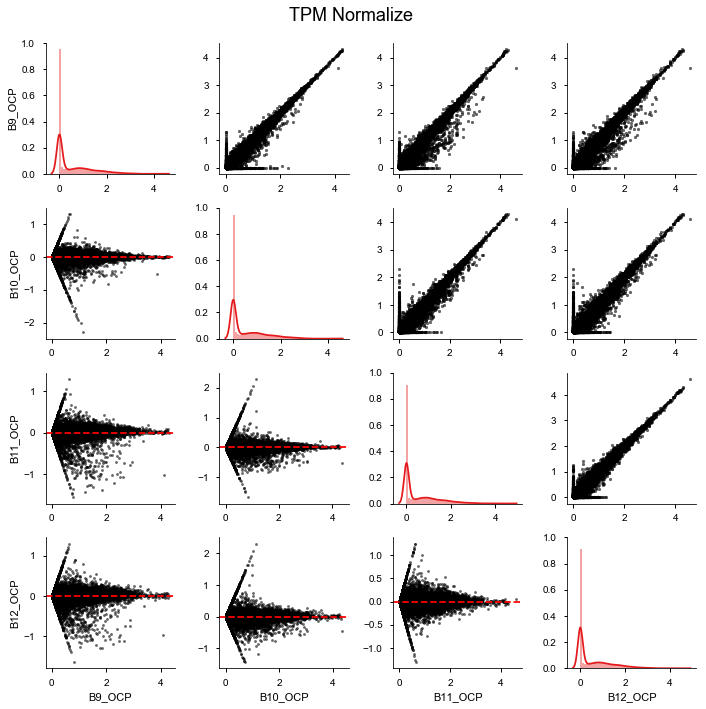

In [12]:
# Compare
g = PairGrid(np.log10(df_tpm + 1), subplots_kws={'sharey': False, 'sharex': False})
g.map_upper(plt.scatter, color='k', s=8, alpha=.6)
g.map_lower(maPlot, scatter_kws={'color': 'k', 's': 8, 'alpha': .6})
g.map_diag(sns.distplot)
plt.suptitle('TPM Normalize', fontsize=18)

plt.tight_layout(rect=[0, 0, 1, .95]);

In [13]:
nb1_raw = nb1.seurat.get_raw().sum(axis=1)
nb2_raw = nb2.seurat.get_raw().sum(axis=1)
nb3_raw = nb3.seurat.get_raw().sum(axis=1)

In [14]:
sc = pd.concat([nb1_raw, nb2_raw, nb3_raw], axis=1).fillna(0)
sc.columns = ['Ovary1', 'Ovary2', 'Ovary3']

In [15]:
sc_rpkm = normalize(sc)
sc_tpm = normalize(sc, 'TPM')

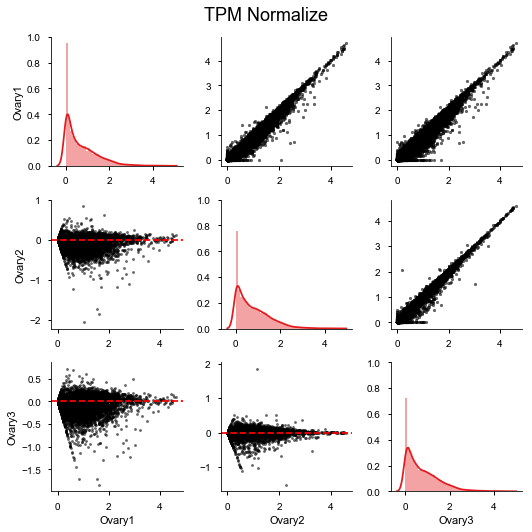

In [16]:
# Compare
g = PairGrid(np.log10(sc_tpm + 1), subplots_kws={'sharey': False, 'sharex': False})
g.map_upper(plt.scatter, color='k', s=8, alpha=.6)
g.map_lower(maPlot, scatter_kws={'color': 'k', 's': 8, 'alpha': .6})
g.map_diag(sns.distplot)
plt.suptitle('TPM Normalize', fontsize=18)

plt.tight_layout(rect=[0, 0, 1, .95]);

In [17]:
combined_tpm = df_tpm.join(sc_tpm, how='inner')

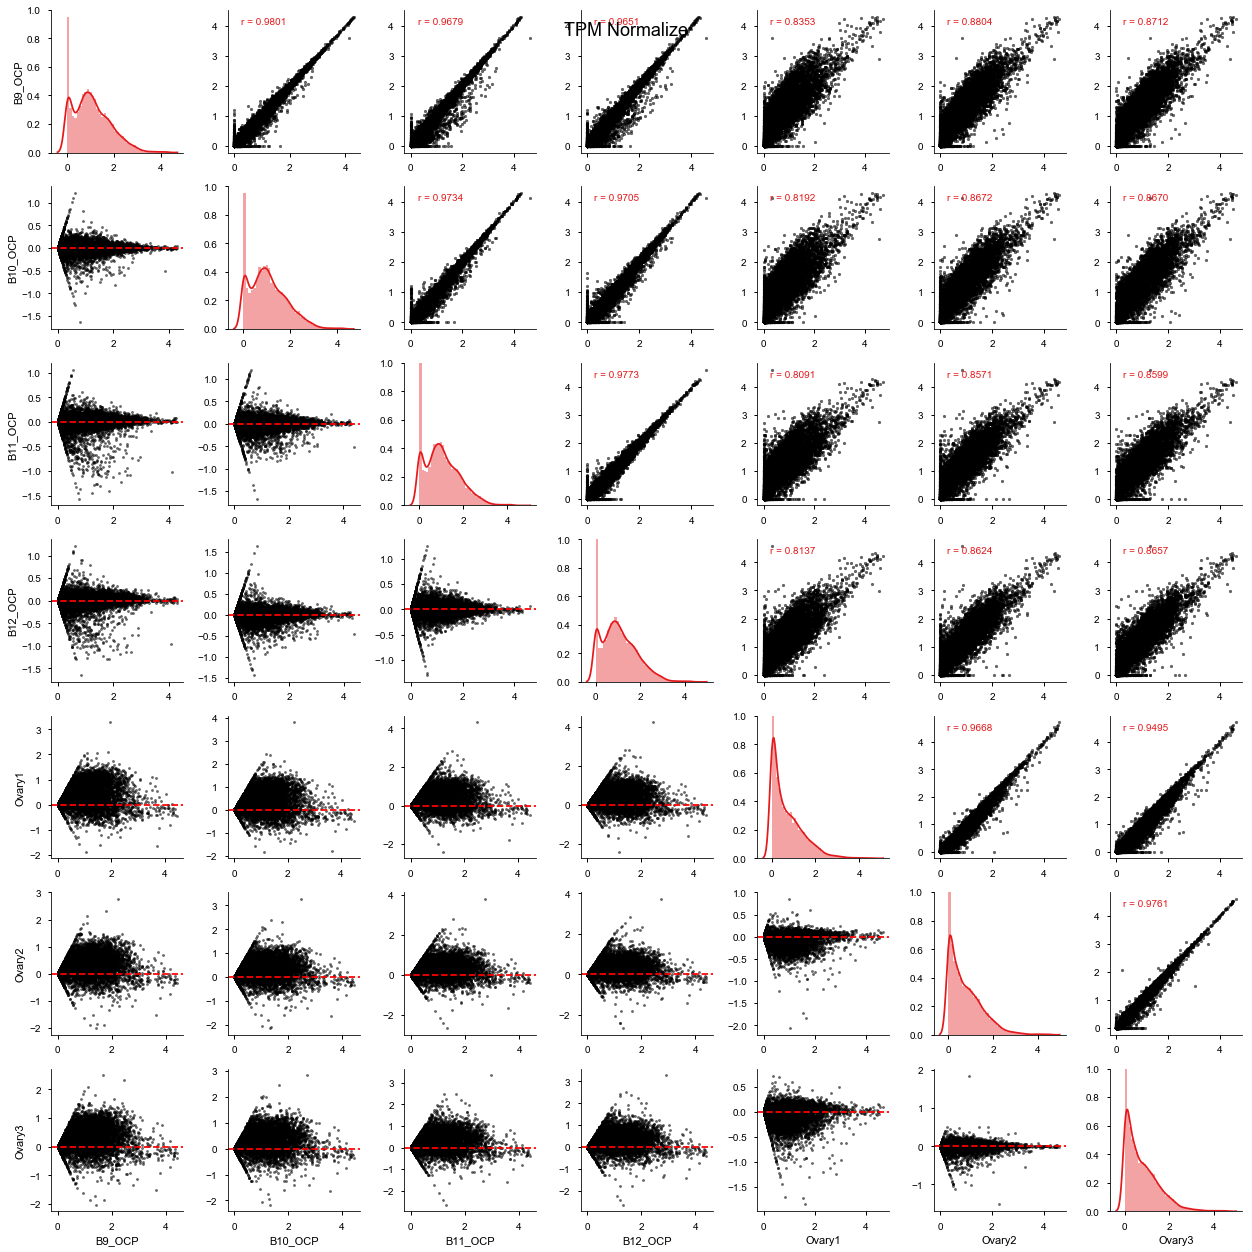

In [20]:
# Compare
@make_figs(nb1.fig_name('pairgrid'), styles=nb1.styles_full, formats=nb1.formats)
def _plot():
    g = PairGrid(np.log10(combined_tpm + 1), subplots_kws={'sharey': False, 'sharex': False})
    g.map_upper(plt.scatter, color='k', s=8, alpha=.6)
    g.map_upper(corrfunc, loc=(.1, .9))
    g.map_lower(maPlot, scatter_kws={'color': 'k', 's': 8, 'alpha': .6})
    g.map_diag(sns.distplot)
    plt.suptitle('TPM Normalize', fontsize=18)

_plot()

In [21]:
combined_tpm.shape

(8779, 7)